# Flight Price Prediction

In [1]:
# Import Dependencies
%matplotlib inline


# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')


# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize


# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv


# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_excel(r"FPPdataset\Data_Train.xlsx")

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [13]:
train_data.shape

(10682, 13)

In [5]:
train_data.info()

# All data is in string type or in object type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [6]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [7]:
train_data.dropna(inplace = True)

In [8]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

## EDA
From description we can see that Date_of_Journey is a object data type,\ Therefore, we have to convert this datatype into timestamp so as to use this column properly for prediction

For this we require pandas to_datetime to convert object data type to datetime dtype.

**.dt.day method will extract only day of that date**\ **.dt.month method will extract only month of that date**

In [9]:
train_data["Journey_day"] = pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.day

In [10]:
train_data["Journey_month"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month

In [11]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [14]:
# Since we have converted Date_of_Journey column into integers, Now we can drop as it is of no use.

train_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [15]:

# Departure time is when a plane leaves the gate. 
# Similar to Date_of_Journey we can extract values from Dep_Time

# Extracting Hours
train_data["Dep_hour"] = pd.to_datetime(train_data["Dep_Time"]).dt.hour

# Extracting Minutes
train_data["Dep_min"] = pd.to_datetime(train_data["Dep_Time"]).dt.minute

# Now we can drop Dep_Time as it is of no use
train_data.drop(["Dep_Time"], axis = 1, inplace = True)

In [16]:
train_data.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,19h,2 stops,No info,13882,9,6,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,23:30,5h 25m,1 stop,No info,6218,12,5,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,21:35,4h 45m,1 stop,No info,13302,1,3,16,50


In [17]:
# Arrival time is when the plane pulls up to the gate.
# Similar to Date_of_Journey we can extract values from Arrival_Time

# Extracting Hours
train_data["Arrival_hour"] = pd.to_datetime(train_data.Arrival_Time).dt.hour

# Extracting Minutes
train_data["Arrival_min"] = pd.to_datetime(train_data.Arrival_Time).dt.minute

# Now we can drop Arrival_Time as it is of no use
train_data.drop(["Arrival_Time"], axis = 1, inplace = True)

In [18]:
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [19]:
# Time taken by plane to reach destination is called Duration
# It is the differnce betwwen Departure Time and Arrival time


# Assigning and converting Duration column into list
duration = list(train_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

In [20]:
# Adding duration_hours and duration_mins list to train_data dataframe

train_data["Duration_hours"] = duration_hours
train_data["Duration_mins"] = duration_mins

In [21]:
train_data.drop(["Duration"], axis = 1, inplace = True)

In [22]:
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


### Handling Categorical Data
One can find many ways to handle categorical data. Some of them categorical data are,

**Nominal data** --> data are not in any order --> **OneHotEncoder** is used in this case<br>
**Ordinal data** --> data are in order --> **LabelEncoder** is used in this case

In [23]:
train_data["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

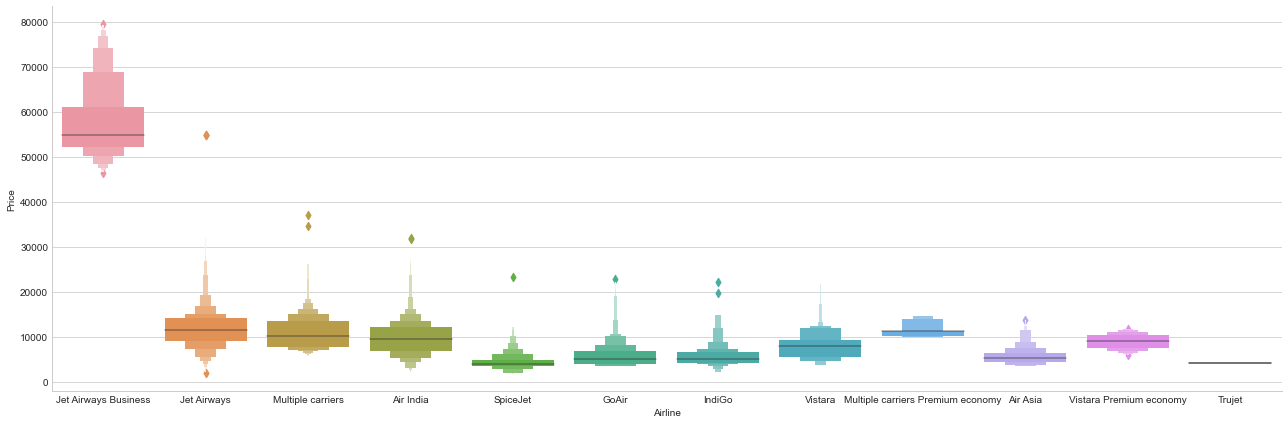

In [24]:
# From graph we can see that Jet Airways Business have the highest Price.
# Apart from the first Airline almost all are having similar median

# Airline vs Price
sns.catplot(y = "Price", x = "Airline", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [25]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding

Airline = train_data[["Airline"]]

Airline = pd.get_dummies(Airline, drop_first= True)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [26]:
train_data["Source"].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

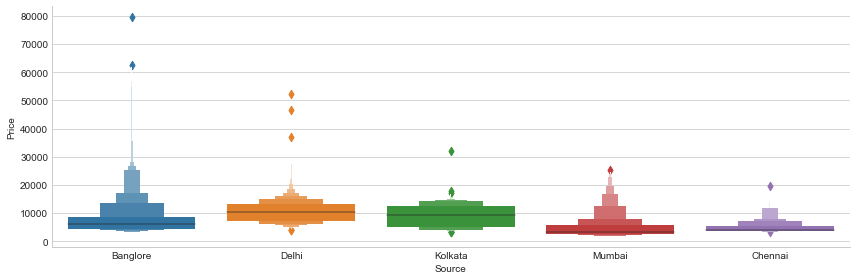

In [27]:
# Source vs Price

sns.catplot(y = "Price", x = "Source", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

In [28]:
# As Source is Nominal Categorical data we will perform OneHotEncoding

Source = train_data[["Source"]]

Source = pd.get_dummies(Source, drop_first= True)

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [29]:
train_data["Destination"].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [30]:
# As Destination is Nominal Categorical data we will perform OneHotEncoding

Destination = train_data[["Destination"]]

Destination = pd.get_dummies(Destination, drop_first = True)

Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [31]:
train_data["Route"]

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10682, dtype: object

In [32]:
# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other

train_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [33]:
train_data["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [34]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys

train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [36]:
# Concatenate dataframe --> train_data + Airline + Source + Destination

data_train = pd.concat([train_data, Airline, Source, Destination], axis = 1)

In [37]:
data_train.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [38]:
data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [39]:
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [40]:
data_train.shape

(10682, 30)

# Test set

In [41]:
test_data = pd.read_excel(r"FPPdataset\Test_set.xlsx")

In [42]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [43]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [44]:
test_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [45]:
# Date_of_Journey
test_data["Journey_day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [46]:
# Dep_Time
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

In [47]:
# Arrival_Time
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

In [48]:
# Duration
duration = list(test_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

In [49]:
# Adding Duration column to test set
test_data["Duration_hours"] = duration_hours
test_data["Duration_mins"] = duration_mins
test_data.drop(["Duration"], axis = 1, inplace = True)

In [50]:
print(test_data["Airline"].value_counts())
Airline = pd.get_dummies(test_data["Airline"], drop_first= True)

Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Vistara Premium economy                2
Jet Airways Business                   2
Name: Airline, dtype: int64


In [51]:
print(test_data["Source"].value_counts())
Source = pd.get_dummies(test_data["Source"], drop_first= True)

Delhi       1145
Kolkata      710
Banglore     555
Mumbai       186
Chennai       75
Name: Source, dtype: int64


In [52]:
print(test_data["Destination"].value_counts())
Destination = pd.get_dummies(test_data["Destination"], drop_first = True)

Cochin       1145
Banglore      710
Delhi         317
New Delhi     238
Hyderabad     186
Kolkata        75
Name: Destination, dtype: int64


In [53]:
# Route and Total_Stops are related to each other
test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [54]:
# Replacing Total_Stops
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [55]:
# Concatenate dataframe --> test_data + Airline + Source + Destination
data_test = pd.concat([test_data, Airline, Source, Destination], axis = 1)

data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [56]:
 data_test.shape

(2671, 28)

## Feature Selection
Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

1.**heatmap**<br>
2.**feature_importance_**<br>
3.**SelectKBest**

In [57]:
data_train.shape

(10682, 30)

In [58]:
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [59]:
X = data_train.loc[:, ['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi']]
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [60]:
y = data_train.iloc[:, 1]
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

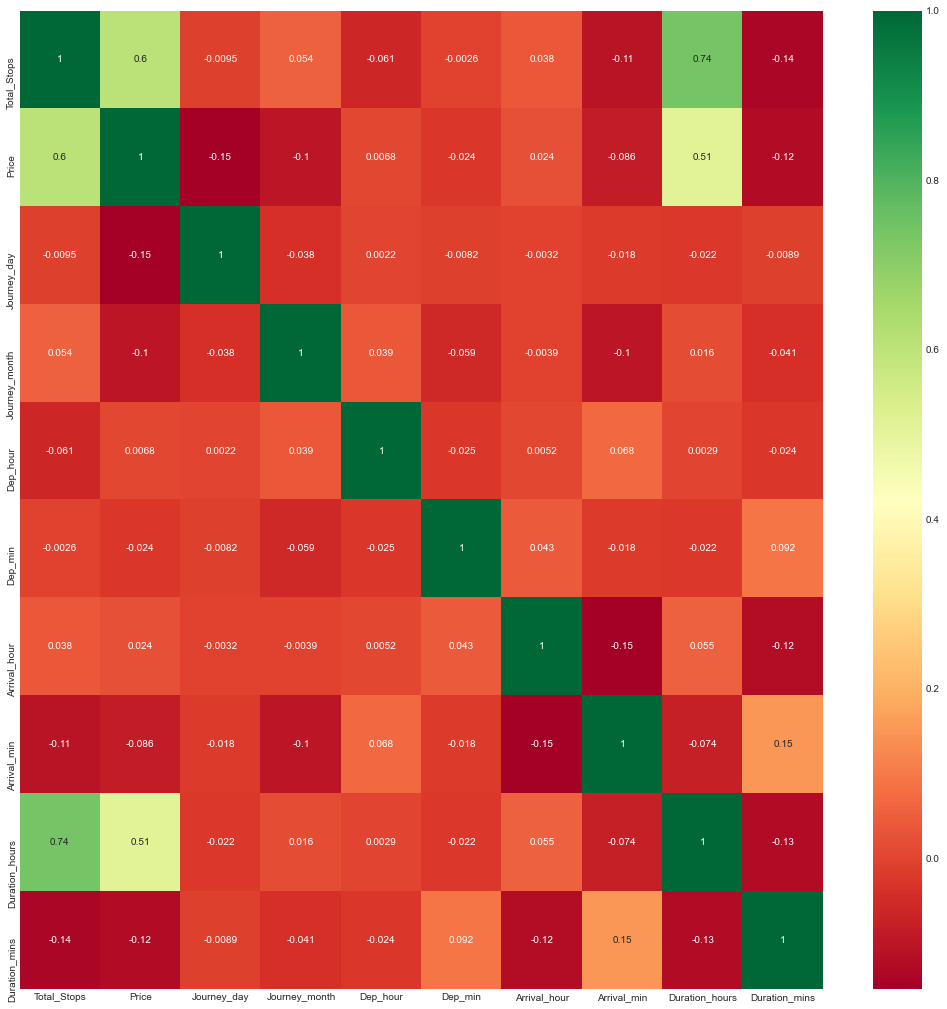

In [61]:
# Finds correlation between Independent and dependent attributes

plt.figure(figsize = (18,18))
sns.heatmap(train_data.corr(), annot = True, cmap = "RdYlGn")

plt.show()

In [62]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [63]:
selection.feature_importances_

array([2.14482630e-01, 1.44275261e-01, 5.30085763e-02, 2.39539097e-02,
       2.09766429e-02, 2.83512712e-02, 1.90365426e-02, 1.38054987e-01,
       1.80222059e-02, 8.43047345e-03, 1.90155387e-03, 1.66023934e-02,
       1.40977922e-01, 6.75506556e-02, 1.94128851e-02, 8.24339280e-04,
       3.13241157e-03, 1.10602950e-04, 4.85205259e-03, 8.55298288e-05,
       5.32241482e-04, 6.97111091e-03, 3.50523954e-03, 7.17612210e-03,
       1.03382901e-02, 1.64646357e-02, 5.58625976e-03, 4.47963805e-04,
       2.49352907e-02])

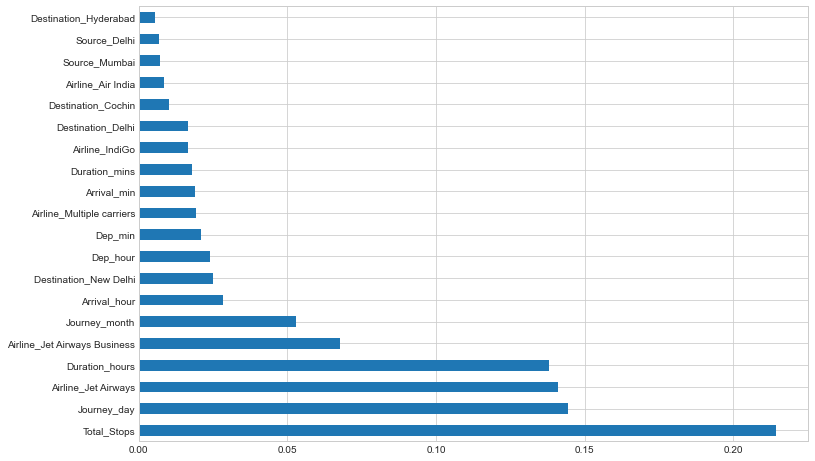

In [64]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

## Define a function to fit machine learning algorithms
Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [65]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## K-Nearest Neighbours

In [67]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 44.99
Accuracy CV 10-Fold: 23.17
Running Time: 0:00:06.031448


## Decision Tree Classifier

In [68]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 88.12
Accuracy CV 10-Fold: 37.36
Running Time: 0:00:03.798089


In [72]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [73]:
y_pred = reg_rf.predict(X_test)

In [74]:
reg_rf.score(X_train, y_train)

0.9531413472106424

In [75]:
reg_rf.score(X_test, y_test)

0.7961011574138039

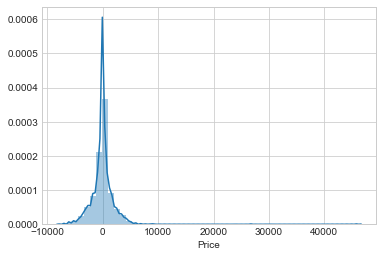

In [76]:
sns.distplot(y_test-y_pred)
plt.show()

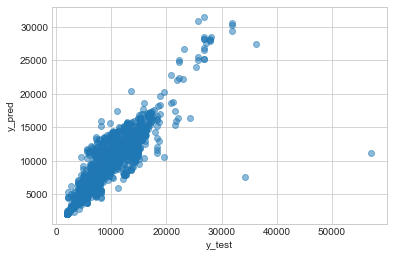

In [77]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [78]:
from sklearn import metrics

In [79]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1181.808951577747
MSE: 4396478.328274959
RMSE: 2096.778082743846


In [80]:
# RMSE/(max(DV)-min(DV))

2090.5509/(max(y)-min(y))

0.026887077025966846

In [81]:
metrics.r2_score(y_test, y_pred)

0.7961011574138039

# Hyperparameter Tuning
Choose following method for hyperparameter tuning <br>
RandomizedSearchCV --> Fast<br>
GridSearchCV<br>
Assign hyperparameters in form of dictionery<br>
Fit the model<br>
Check best paramters and best score<br>

In [82]:
from sklearn.model_selection import RandomizedSearchCV

In [83]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [84]:
n_estimators

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

In [85]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [86]:

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [87]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.7s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.7s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   5.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.4s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   5.5s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   9.3s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.7s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.7s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   3.2s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [88]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [89]:
prediction = rf_random.predict(X_test)

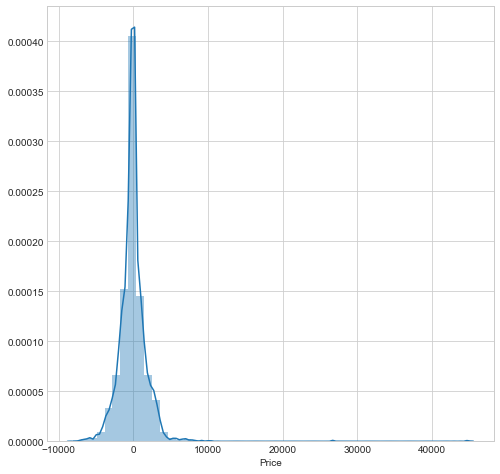

In [90]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

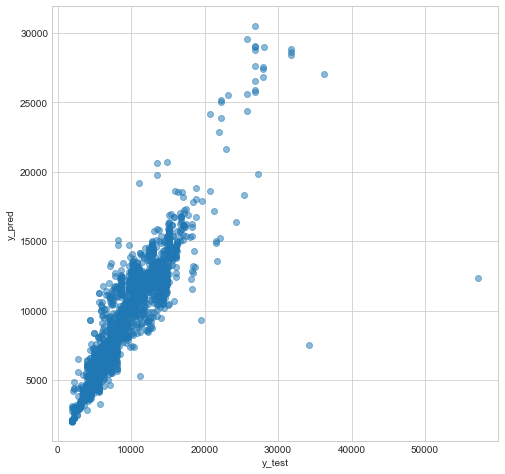

In [91]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [92]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1164.8182166454994
MSE: 4038057.903973727
RMSE: 2009.4919517066314


# Save the model to reuse it again

In [98]:
import pickle
# open a file, where you ant to store the data
file = open('flight_rf.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)

In [99]:
model = open('flight_rf.pkl','rb')
forest = pickle.load(model)

In [100]:
y_prediction = forest.predict(X_test)

In [101]:
metrics.r2_score(y_test, y_prediction)

0.8127238959371049